In [1]:
#importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import time
import pylab as pl
import gmsh
from IPython import display
from matplotlib.path import Path
from scipy.sparse import coo_array
from collections import Counter
%matplotlib inline
import scipy
import time
from multiprocessing import Pool
from worker import matrix_helper

In [2]:
def read_mesh(filepath):
    '''
    Takes in an msh file and should return nodal coordinates and element connectivity in each physical group along with the boundary nodes 
    '''
    gmsh.initialize()
    gmsh.open(filepath)
    print(f"Reading {filepath}")
    print(f"Number of nodes in the mesh: {int(gmsh.option.getNumber("Mesh.NbNodes"))}")
    print(f"Number of triangles in the mesh: {int(gmsh.option.getNumber("Mesh.NbTriangles"))}\n")

    #Get all nodes
    dim = -1
    tag = -1
    nodeTags, nodecoords, _ = gmsh.model.mesh.getNodes(dim,tag)
    nodecoords = nodecoords.reshape(-1,3) #tags start from 1

    #Get all triangles
    eleType = 2
    tag = -1
    elements_t,ele_con = gmsh.model.mesh.getElementsByType(eleType,-1)
    ele_con = ele_con.reshape(-1,3)  #tags start from 1


    gmsh.finalize()
    return [nodecoords,ele_con] 

In [3]:
def Q(point,centre,ro):
    x = point[0,0] - centre[0,0]
    y = point[0,1] - centre[0,1]
    Qo = 5 ## amplitude in W/mm^2 
    return Qo*np.exp(-(x**2+y**2)/ro**2)  ## W/m^3

def rho_Ti(T, phase = 'alpha'):
    if phase == 'alpha':
        return -5.13e-5*(T**2)-0.01935*T+4451
    elif phase == 'beta':
        return -2.762e-6*(T**2)-0.1663*T+4468
    elif phase == 'liquid':
        return -0.565*T+5093
    else:
        return T

def cp_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.25*T+483
    elif phase == 'beta':
        return 0.14*T+530
    elif phase == 'liquid':
        return 930
    else:
        return T

def k_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.012*T+3.3
    elif phase == 'beta':
        return 0.016*T-3
    elif phase == 'liquid':
        return 0.0175*T-4.5
    else:
        return T

def props_chooser(T, T_rep, process = 'heating'):
    if (T_rep<1268 and process == 'heating') or (T_rep<=1073 and process == 'cooling'):
        return rho_Ti(T,phase = 'alpha'),cp_Ti(T,phase = 'alpha'),k_Ti(T,phase = 'alpha')
    elif (T_rep<1928 and process == 'heating') or (T_rep>1073 and process == 'cooling'):
        return rho_Ti(T,phase = 'beta'),cp_Ti(T,phase = 'beta'),k_Ti(T,phase = 'beta')
    elif (T_rep>=1928 and process == 'heating') or (T_rep>=1878 and process == 'cooling'):
        return rho_Ti(T,phase = 'liquid'),cp_Ti(T,phase = 'liquid'),k_Ti(T,phase = 'liquid')
    else:
        return -1
        
def flatten(xss):
    return [x for xs in xss for x in xs]   

In [18]:
class FEM:
    def __init__(self,nodecoords,elecon,centre):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
        self.nodecoords = nodecoords
        self.elecon = elecon
        self.K_row,self.K_col,self.K_data = [],[],[]
        self.G_row,self.G_col,self.G_data = [],[],[]
        self.nop = nodecoords.shape[0]
        self.F = np.zeros((self.nop,1))
        self.boundary_term = np.zeros((self.nop,1))
        self.areas = []
        self.centre = centre
    
    def fit_ele(self,nodes,ele,theta_prev_time = None,theta_prev_pic = None,mode = "linear",verbose = False):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''

        self.nodecoords = nodes
        self.elecon = ele
        
        gp = 3

        qo = -1e-3   # W/mm^2
        c = 658 #J/kg.K
        rho = 7.6e-6 #kg/mm^3
        kappa = 0.025 #W/mm.K
        ro = 2 #mm
        vo = 2 #mm/s
        
        #getting in the required data and doing the initialization
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K = np.zeros((nop,nop))
        G = np.zeros((nop,nop))
        K_row,K_col,K_data = [],[],[]
        G_row,G_col,G_data = [],[],[]
        # F = np.zeros((nop,1))
        # boundary_term = np.zeros((nop,1))

        ln = np.where(nodes[:,0] == 0)[0]
        rn = np.where(nodes[:,0] == np.max(nodes[:,0]))[0]
        bn = np.where(nodes[:,1] == 0)[0]
        tn = np.where(nodes[:,1] == np.max(nodes[:,1]))[0]

        items = [(nodes,elei,self.centre,theta_prev_time,theta_prev_pic,mode) for elei in ele]
        st = time.time()
        with Pool() as pool:
            results = pool.map(matrix_helper, items)

        K_row, K_col, K_data, G_row, G_col, G_data, F_row,F_data, BT_row, BT_data,areas = list(zip(*results))
        mega = [K_row, K_col, K_data, G_row, G_col, G_data, F_row,F_data, BT_row, BT_data]
        K_row, K_col, K_data, G_row, G_col, G_data, F_row,F_data, BT_row, BT_data = [flatten(mini) for mini in mega]

        F= coo_array((F_data,(F_row,[0]*len(F_row))),shape = ((nop,1))).toarray()
        boundary_term = coo_array((BT_data,(BT_row,[0]*len(BT_row))),shape = ((nop,1))).toarray()
        # for elei in ele:
        #     self.matrix_helper(elei,theta_prev_time = theta_prev_time,theta_prev_pic = theta_prev_pic,mode = mode)

        
        if verbose == True:
            print(f"Mesh size is {np.sqrt(np.mean(areas))}")
            print(f"Spot radius is {ro}")
        T_l = 273+20

        print(f"Time for loop to end {time.time()-st}")
        st = time.time()
        K_sparse = coo_array((K_data,(K_row,K_col)),shape=(nop,nop))
        G_sparse = coo_array((G_data,(G_row,G_col)),shape=(nop,nop))
        print(f"Time for sparse conversion {time.time()-st}")

        st = time.time()
        K = K_sparse.toarray()
        G = G_sparse.toarray()
        print(f"Time for sparse to dense conversion {time.time()-st}")
        
        non_ln = np.setdiff1d(np.arange(K.shape[0]),ln)
        rhs = F+boundary_term-T_l*np.sum((K[np.ix_(np.arange(K.shape[0]),ln)]\
                                          +G[np.ix_(np.arange(K.shape[0]),ln)]),axis = 1).reshape(-1,1)
        K_sub = K[np.ix_(non_ln,non_ln)]
        G_sub = G[np.ix_(non_ln,non_ln)]
        rhs_sub = rhs[np.ix_(non_ln,[0])]

        K_sparse = coo_array(K_sub)
        G_sparse = coo_array(G_sub)
        rhs_sparse = coo_array(rhs_sub)
        st = time.time()
        theta_sub = scipy.sparse.linalg.spsolve(K_sparse+G_sparse,rhs_sparse)
        print(f"Time for inversion {time.time()-st}")

        theta = np.zeros((K.shape[0],1))+T_l
        theta[non_ln,:] = theta_sub.reshape(-1,1)
        
        return [K,G,F,boundary_term,theta]


In [19]:
mesh_size_factor = 2

In [20]:
filename = f"rectangle_{mesh_size_factor}.msh"
# filename = f"rectangle_vary_0.5_1.msh"
nodecoords,ele_con = read_mesh(filename) #node tags start from 1
soln1 = FEM(nodecoords,ele_con,np.array([[50,25]]))
K,G,F,boundary,theta = soln1.fit_ele(nodecoords,ele_con,verbose = True)

Reading rectangle_2.msh
Number of nodes in the mesh: 1542
Number of triangles in the mesh: 2932

Mesh size is 1.3058792441389253
Spot radius is 2
Time for loop to end 0.7950313091278076
Time for sparse conversion 0.03124260902404785
Time for sparse to dense conversion 0.01562190055847168
Time for inversion 0.0


In [21]:
print(np.sum(boundary))

0.25000000000000006


In [7]:
print(np.sum(K))

1.1796119636642288e-15


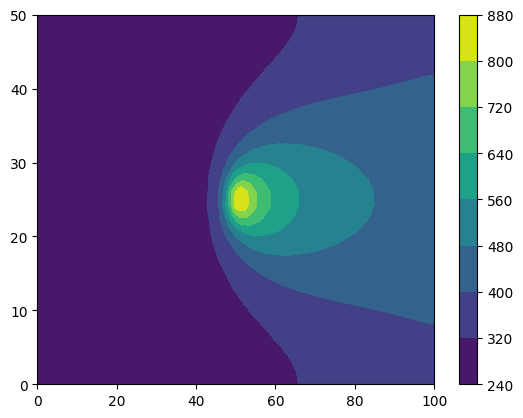

In [8]:
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten())
plt.colorbar()
plt.show()

In [9]:
print(np.max(theta))

868.7619154376979


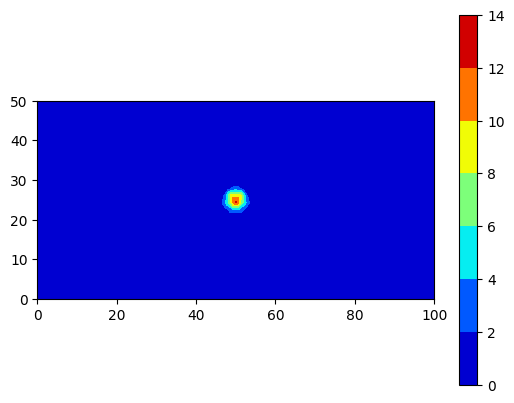

In [10]:
### Plotting the gaussian
plt.tricontourf(nodecoords[:,0],nodecoords[:,1], F.flatten(),cmap = 'jet')
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()

## Picard iteration for moving source heat conduction

In [19]:
def picard(nodecoords,ele_con,theta_init,source):
## the idea is you initialize a temperature profile and find corresponding multipliers for the non linear terms
    #non is number of nodes
    theta_old = theta_init

    e = 1e5
    tolerance = 1e-4
    iter = 0
    
    while(e>tolerance):
        iter +=1
        _,_,_,_,theta_new = FEM(nodecoords,ele_con,source).fit_ele(nodecoords,ele_con,theta_prev_time = theta_init,theta_prev_pic = theta_old,mode = "non_linear")
        e = np.linalg.norm(theta_new - theta_old)
        theta_old = theta_new
        print(f"Error at {iter} iteration is {e:.2E}")
        # print(theta_init)

    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta_new.flatten())
    plt.title(f"Converged solution after {iter} iterations")
    plt.colorbar()
    plt.show()

    return theta_new
        
        

Time is 0 seconds
Time for loop to end 9.735425233840942
Time for sparse conversion 0.24905848503112793
Time for sparse to dense conversion 0.15459299087524414
Time for inversion 0.9836187362670898
Error at 1 iteration is 8.44E+04
Time for loop to end 9.76410460472107
Time for sparse conversion 0.23567628860473633
Time for sparse to dense conversion 0.09644317626953125
Time for inversion 0.1283261775970459
Error at 2 iteration is 1.12E+04
Time for loop to end 6.321472883224487
Time for sparse conversion 0.21796107292175293
Time for sparse to dense conversion 0.16020512580871582
Time for inversion 0.10980486869812012
Error at 3 iteration is 1.61E+03
Time for loop to end 6.72988486289978
Time for sparse conversion 0.26596593856811523
Time for sparse to dense conversion 0.14502811431884766
Time for inversion 0.10985898971557617
Error at 4 iteration is 4.52E+02
Time for loop to end 6.122761487960815
Time for sparse conversion 0.20427441596984863
Time for sparse to dense conversion 0.109740

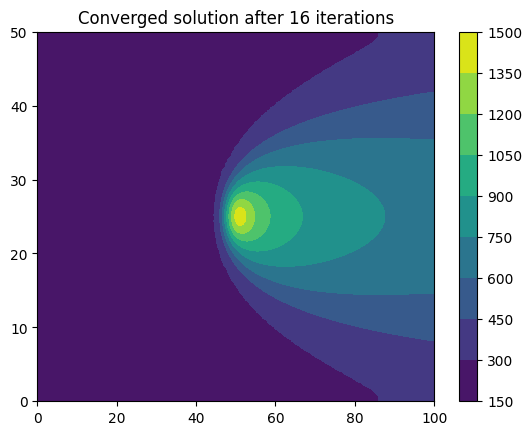

Time is 1 seconds
Time for loop to end 6.135739803314209


In [ ]:
T_l = 273+1000
t_final = 10
times = np.arange(0,t_final,1)
theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
x_source = 50
for t in times:
    print(f"Time is {t} seconds")
    theta_final = picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source+2*t,25]]))
    theta_prev = theta_final

In [119]:
np.max(theta_final)

np.float64(1299.4449254020838)

## Picard iteration validation

In [13]:
def Q(point):
    x = point[0,0] #in mm
    return 15e-3*(x/100)*(1-x/100) ## W/mm^3

def k_T(T):
    # return np.ones_like(T)*110
    return (100+0.004*(T-50-273)**2)*1e-3  ##W/mmK

In [14]:
class Picard_valid:
    def __init__(self):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
                        
    def fit_ele(self,nodes,ele,dt,theta_prev_time = None,theta_prev_pic = None,mode = "linear",scheme = "implicit"):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''
        gp = 3

        qo = 0   # W/mm^2
        c = 465 #J/kg.K
        rho = 7e-6 #kg/mm^3
        
        #getting in the required data and doing the initialization
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K = np.zeros((nop,nop))
        M = np.zeros((nop,nop))
        F = np.zeros((nop,1))
        boundary_term = np.zeros((nop,1))

        ln = np.where(nodes[:,0] == 0)[0]
        rn = np.where(nodes[:,0] == np.max(nodes[:,0]))[0]
        bn = np.where(nodes[:,1] == 0)[0]
        tn = np.where(nodes[:,1] == np.max(nodes[:,1]))[0]

        for i,elei in enumerate(ele):
            econ = elei-1
            boundary = nodes[np.ix_(econ,[0,1])]
            dN = np.array([[-1,1,0],[-1,0,1]])
            Jac = np.matmul(dN,boundary)
            if np.linalg.det(Jac)<0:
                econ[0],econ[1] = econ[1],econ[0] #reordering for the direction to be counter clockwise
                boundary = nodes[np.ix_(econ,[0,1])] 
                Jac = np.matmul(dN,boundary)
            dN_dx = (np.linalg.inv(Jac)@dN)[0].reshape(1,-1) #1x3
            Jac_inv = np.linalg.inv(Jac)
            for j,ipj in enumerate(ips):
                N = np.array([[(1-ipj[0]-ipj[1]), ipj[0],ipj[1]]])
                a = (Jac_inv@dN).T@(Jac_inv@dN)*(np.linalg.det(Jac))*weights[j]
                b = N.T@dN_dx*(np.linalg.det(Jac))*weights[j]
                m = np.matmul(N.T,N)*np.linalg.det(Jac)*weights[j]
                if mode == "non_linear":
                    kappa = N@k_T(theta_prev_pic[np.ix_(econ,[0])])
                K[np.ix_(econ,econ)] += kappa*a
                M[np.ix_(econ,econ)] += rho*c*m
                # G[np.ix_(econ,econ)] += rho*c*vo*b
                X  =np.matmul(N,boundary)
                f = N*Q(X)*np.linalg.det(Jac)*weights[j]
                F[np.ix_(econ,[0])] +=f.T


        T_b = 273+100
        non_bn = np.setdiff1d(np.arange(K.shape[0]),bn)
        rhs = (F+boundary_term+M@theta_prev_time/dt)\
               -T_b*np.sum(K[np.ix_(np.arange(K.shape[0]),bn)]+M[np.ix_(np.arange(K.shape[0]),bn)]/dt,axis = 1).reshape(-1,1)
        K_sub = K[np.ix_(non_bn,non_bn)]
        M_sub = M[np.ix_(non_bn,non_bn)]
        rhs_sub = rhs[np.ix_(non_bn,[0])]
        # print(K_sub)
        # print(np.sum(M_sub))
        # print(K_sub+M_sub/dt)
        # print("inverter:",np.sum(np.linalg.inv(K_sub+M_sub/dt)))
        # print("multiplier:",np.sum(((F+boundary_term+M@(theta_prev_time-273)/dt)\
        #        -(T_b-273)*np.sum(K[np.ix_(np.arange(K.shape[0]),bn)]+M[np.ix_(np.arange(K.shape[0]),bn)]/dt,axis = 1).reshape(-1,1))[np.ix_(non_bn,[0])]))
        # return
        theta_sub = np.linalg.inv(K_sub+M_sub/dt)@(rhs_sub)

        theta = np.zeros((K.shape[0],1))+T_b
        theta[non_bn,:] = theta_sub.reshape(-1,1)
        
        return [M,K,F,boundary_term,theta]

In [15]:
def picard(soln,nodecoords,ele_con,theta_init):
## the idea is you initialize a temperature profile and find corresponding multipliers for the non linear terms
    #non is number of nodes

    dt = 1
    times = np.arange(0,10,dt)
    theta_prev_time = theta_init
    
    for t in times:
        if t == round(t):
            print(np.min(theta_prev_time)-273,' at ',nodecoords[np.argmin(theta_prev_time)])
            print(np.max(theta_prev_time)-273,' at ',nodecoords[np.argmax(theta_prev_time)])
        e = 1e5
        tolerance = 1e-4
        iter = 0
        theta_prev_pic = theta_prev_time
        while(e>tolerance):
            iter +=1
            ## Implicit formulation 
            M,K,F,boundary_term,theta_new = soln.fit_ele(nodecoords,ele_con,dt,theta_prev_time = theta_prev_time,theta_prev_pic = theta_prev_pic,mode = "non_linear",scheme = "implicit")
            # print("M:",np.sum(M))
            # print("K:",np.sum(K))
            # print("F:",np.sum(F))
            # print("boundary_term:",np.sum(boundary_term))
            e = np.linalg.norm(theta_new - theta_prev_pic)
            theta_prev_pic = theta_new
            if t == round(t):
                print(f"Error at {iter} iteration at time {t} is {e:.2E}")
        # print(np.any(boundary_term))  confirmation that b.t isn't contributing
        theta_prev_time = theta_new
        
    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta_new.flatten()-273, cmap = 'plasma')
    plt.title(f"Converged solution")
    plt.colorbar()
    plt.show()

    return theta_new
        

In [16]:
mesh_size_factor = 3
filename = f"square_{mesh_size_factor}.msh"
nodecoords,ele_con = read_mesh(filename) #node tags start from 1

Reading square_3.msh
Number of nodes in the mesh: 380
Number of triangles in the mesh: 690



50.0  at  [100. 100.   0.]
50.0  at  [100. 100.   0.]
Error at 1 iteration at time 0 is 2.34E+02
Error at 2 iteration at time 0 is 3.52E+00
Error at 3 iteration at time 0 is 3.69E-02
Error at 4 iteration at time 0 is 2.79E-04
Error at 5 iteration at time 0 is 1.79E-06
50.21715085157712  at  [100. 100.   0.]
100.0  at  [100.   0.   0.]
Error at 1 iteration at time 1 is 6.46E+01
Error at 2 iteration at time 1 is 4.82E-01
Error at 3 iteration at time 1 is 2.65E-03
Error at 4 iteration at time 1 is 1.24E-05
50.5384875579075  at  [100. 100.   0.]
100.0  at  [100.   0.   0.]
Error at 1 iteration at time 2 is 4.52E+01
Error at 2 iteration at time 2 is 2.56E-01
Error at 3 iteration at time 2 is 1.29E-03
Error at 4 iteration at time 2 is 1.17E-05
50.92924218714677  at  [100. 100.   0.]
100.0  at  [100.   0.   0.]
Error at 1 iteration at time 3 is 3.69E+01
Error at 2 iteration at time 3 is 1.62E-01
Error at 3 iteration at time 3 is 9.17E-04
Error at 4 iteration at time 3 is 8.05E-06
51.372609065

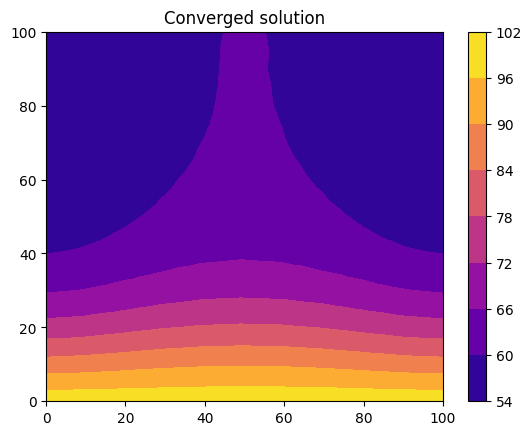

In [17]:
soln3 = Picard_valid()
T_b = 273+50
theta_init = np.zeros((nodecoords.shape[0],1))+T_b
theta_final = picard(soln3,nodecoords,ele_con,theta_init)

In [18]:
#at node a
theta_final[np.where((nodecoords[:,0] == 0) * (nodecoords[:,1] == 100)) [0][0]]-273

array([54.74332597])

In [19]:
#at node b
theta_final[np.where((nodecoords[:,0] == 100) * (nodecoords[:,1] == 100)) [0][0]]-273

array([54.74224726])

In [70]:
a = [(1,2),(3,4)]

In [71]:
list(zip(*a))

[(1, 3), (2, 4)]